In [5]:
from neuralNet import MatrixNeuralNet
from pdes import LinearQuadraticRegulator2D
import matplotlib.pyplot as plt
import numpy as np

In [7]:
layers = [2, 50, 50, 50, 3]
network = MatrixNeuralNet( layers)
gamma = {'data': 0, 'gradient': 0, 'residual': 1, 'matrix': 0}
pde = LinearQuadraticRegulator2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=100,
    dataPointCount=100,
    lrs=lrs,
    iterations=iterations
    )

xInt:  torch.Size([100, 2])
xData:  torch.Size([100, 2])


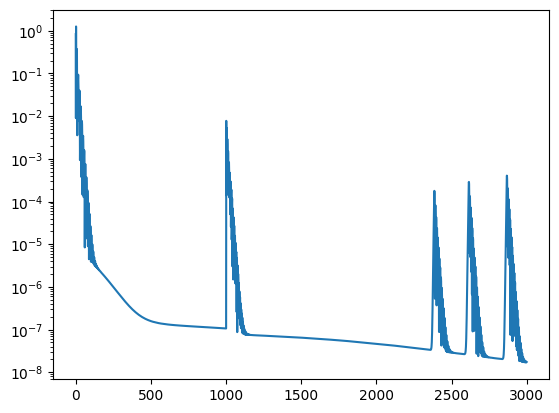

In [8]:
ax = resu['loss'].plot()
ax.set_yscale("log")

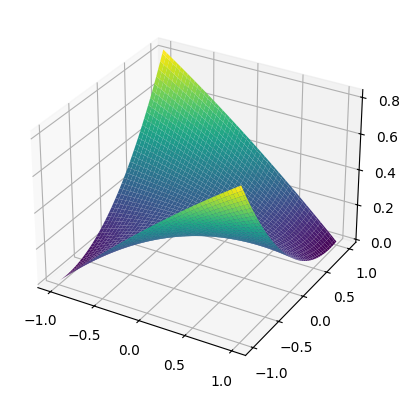

In [9]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');